<a href="https://colab.research.google.com/github/cheongyeechian/DLI/blob/main/Cheong_Yee_Chian_Individual_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Title: Phishing Website Detection using Machine Learning
This is the [research paper and github](https://github.com/asrith-reddy/Phishing-detector/blob/main/Project%20document.pdf) that i used.

To obtain the dataset, please download from [github](https://github.com/cheongyeechian/DLI/blob/main/Cheong_Yee_Chian-TP073642/dataset_phishing.csv)

# Machine Learning Model
I am using **Logistic Regression** for this individual assignment and comparing my model’s accuracy with the Logistic Regression results reported by the author.

Below is my model code 👇🏻

Enjoy.

**The model accuracy reported by the research author is:**

Accuracy: 0.934
F1_Score: 0.941
Recall: 0.943
Precision: 0.947

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import os


if not os.path.exists("dataset_phishing.csv"):
    try:
        # Download the file from Google Drive
        !gdown --id 1QrsbselQT_UPK81Pur_rigCKyZKpE9Zq -O dataset_phishing.csv
        print("Dataset downloaded successfully!")
    except Exception as e:
        print(f"Error downloading dataset: {e}")
        exit()

# Load the dataset
try:
    df = pd.read_csv("dataset_phishing.csv")
    print("Dataset loaded successfully!")
    print("\nFirst 5 rows of the dataset:")
    print(df.head())
    print("\nShape of the dataset (rows, columns):")
    print(df.shape)
    print("\nInformation about the dataset (data types, non-null counts):")
    df.info()
    print("\nDistribution of the target variable (status):")
    print(df['status'].value_counts())
except FileNotFoundError:
    print("Error: 'dataset_phishing.csv' not found after download attempt.")
    exit()
except Exception as e:
    print(f"An error occurred during data loading: {e}")
    exit()


print("\n--- Data Cleaning and Preprocessing ---")

# Drop the 'url' column as it's not needed for the model
if 'url' in df.columns:
    df = df.drop("url", axis=1)
    print("'url' column dropped.")
else:
    print("'url' column not found.")

# Encode the 'status' column using LabelEncoder
if 'status' in df.columns:
    label_encoder = LabelEncoder()
    df["status_encoding"] = label_encoder.fit_transform(df["status"])
    status_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    print(f"Status column encoded. Mapping: {status_mapping}")
    df = df.drop("status", axis=1)
    print("Original 'status' column dropped.")
else:
    print("'status' column not found or already processed.")


# Handle -1 values in 'domain_age' and 'domain_registration_length'
print("\nHandling -1 values in 'domain_age' and 'domain_registration_length'...")

# Calculate the mean of the relevant columns excluding -1
mean_domain_age = df[df['domain_age'] != -1]['domain_age'].mean()
mean_domain_registration_length = df[df['domain_registration_length'] != -1]['domain_registration_length'].mean()

# Replace -1 values with the calculated means
df['domain_age'] = df['domain_age'].replace(-1, mean_domain_age)
df['domain_registration_length'] = df['domain_registration_length'].replace(-1, mean_domain_registration_length)

print(f"Replaced -1 in 'domain_age' with mean: {mean_domain_age:.2f}")
print(f"Replaced -1 in 'domain_registration_length' with mean: {mean_domain_registration_length:.2f}")


# Define features (X) and target (y)
X = df.drop('status_encoding', axis=1)
y = df['status_encoding']

print(f"\nFeatures (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set features (X_train) shape: {X_train.shape}")
print(f"Testing set features (X_test) shape: {X_test.shape}")
print(f"Training set target (y_train) shape: {y_train.shape}")
print(f"Testing set target (y_test) shape: {y_test.shape}")

print("\nPreprocessing complete. Data is ready for model training.")

Dataset loaded successfully!

First 5 rows of the dataset:
                                                 url  length_url  \
0              http://www.crestonwood.com/router.php          37   
1  http://shadetreetechnology.com/V4/validation/a...          77   
2  https://support-appleld.com.secureupdate.duila...         126   
3                                 http://rgipt.ac.in          18   
4  http://www.iracing.com/tracks/gateway-motorspo...          55   

   length_hostname  ip  nb_dots  nb_hyphens  nb_at  nb_qm  nb_and  nb_or  ...  \
0               19   0        3           0      0      0       0      0  ...   
1               23   1        1           0      0      0       0      0  ...   
2               50   1        4           1      0      1       2      0  ...   
3               11   0        2           0      0      0       0      0  ...   
4               15   0        2           2      0      0       0      0  ...   

   domain_in_title  domain_with_copyright  wh

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import os
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
import time # Import the time module

print("\n--- Logistic Regression Model Training with Enhancements ---")

# Start total training timer
total_start_time = time.time()

# 1️⃣ Scale the features
scaler_lr = StandardScaler()
X_train_scaled_lr = scaler_lr.fit_transform(X_train)
X_test_scaled_lr = scaler_lr.transform(X_test)
print("Features scaled for Logistic Regression.")

# 2️⃣ Add polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled_lr)
X_test_poly = poly.transform(X_test_scaled_lr)
print(f"Added polynomial features. New training shape: {X_train_poly.shape}")

# 3️⃣ Hyperparameter tuning with RandomizedSearchCV
print("\nPerforming RandomizedSearchCV for Hyperparameter Tuning...")
start_hyper_time = time.time()  # Timer for RandomizedSearchCV only

param_dist = {'C': loguniform(1e-3, 1e3)}

random_search = RandomizedSearchCV(
    LogisticRegression(random_state=42, penalty='l2', solver='lbfgs', max_iter=2000),
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)
random_search.fit(X_train_poly, y_train)

hyperparameter_time = time.time() - start_hyper_time
best_C = random_search.best_params_['C']
print(f"Best C found by RandomizedSearchCV: {best_C}")
print(f"RandomizedSearchCV took {hyperparameter_time/60:.2f} minutes")

# 4️⃣ Train the final model
print("\nTraining final Logistic Regression Model with best C...")
start_model_time = time.time()
model_lr = LogisticRegression(random_state=42, C=best_C, penalty='l2', solver='lbfgs', max_iter=2000)
model_lr.fit(X_train_poly, y_train)
final_model_time = time.time() - start_model_time
print(f"Final model training took {final_model_time:.2f} seconds")

# 5️⃣ Total training time
total_training_time = time.time() - total_start_time
print(f"\nTotal training time (scaling + polynomial + tuning + final model): {total_training_time/60:.2f} minutes")

# 6️⃣ Prediction
print("\nEvaluating Logistic Regression Model...")
start_pred_time = time.time()
y_pred_lr = model_lr.predict(X_test_poly)
prediction_time_lr = time.time() - start_pred_time

accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)

print("\nConfusion Matrix (Logistic Regression):")
print(conf_matrix_lr)

print("\nConclusion")
print(f"Accuracy (Logistic Regression): {accuracy_lr:.4f}")
print(f"Precision (Logistic Regression): {precision_lr:.4f}")
print(f"Recall (Logistic Regression): {recall_lr:.4f}")
print(f"F1-Score (Logistic Regression): {f1_lr:.4f}")
print(f"Prediction time (Logistic Regression): {prediction_time_lr:.4f} seconds")
print(f"Total training time (Logistic Regression): {total_training_time/60:.2f} minutes")



--- Logistic Regression Model Training with Enhancements ---
Features scaled for Logistic Regression.
Added polynomial features. New training shape: (9144, 3915)

Performing RandomizedSearchCV for Hyperparameter Tuning...
Best C found by RandomizedSearchCV: 0.008629132190071854
RandomizedSearchCV took 3.41 minutes

Training final Logistic Regression Model with best C...
Final model training took 17.15 seconds

Total training time (scaling + polynomial + tuning + final model): 3.72 minutes

Evaluating Logistic Regression Model...

Confusion Matrix (Logistic Regression):
[[1101   42]
 [  47 1096]]

Conclusion
Accuracy (Logistic Regression): 0.9611
Precision (Logistic Regression): 0.9631
Recall (Logistic Regression): 0.9589
F1-Score (Logistic Regression): 0.9610
Prediction time (Logistic Regression): 0.0270 seconds
Total training time (Logistic Regression): 3.72 minutes



--- Model Performance Comparison ---


,Metric,My Model,Author's Model
0,Accuracy,0.961067,0.934
1,Precision,0.963093,0.927
2,Recall,0.958880,0.943
3,F1-Score,0.960982,0.941



--- Model Time Comparison ---


,Metric,My Model,Author's Model
0,Training Time (minutes),3.717049,3.50
1,Prediction Time (s),0.026971,0.02


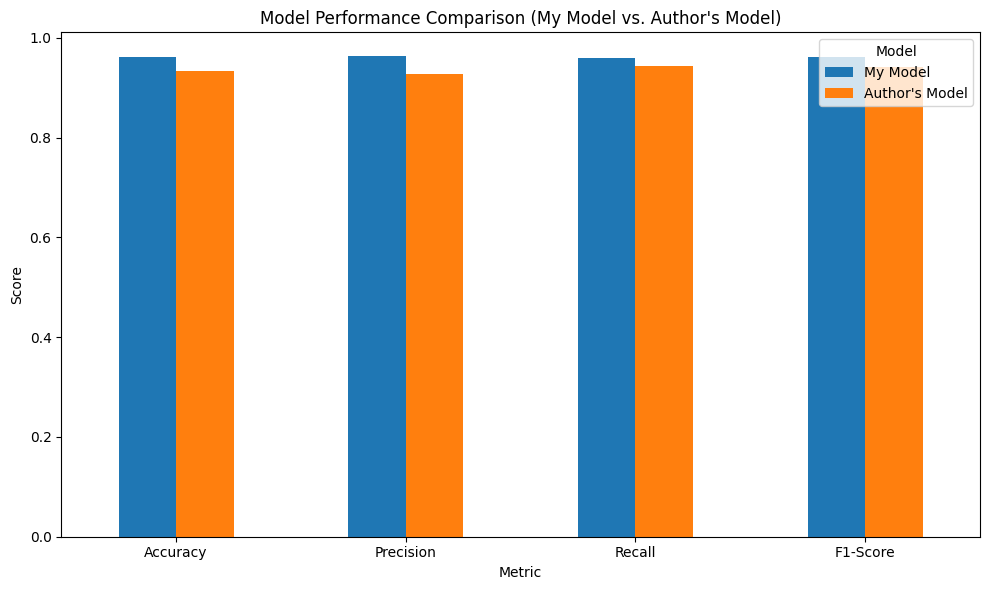

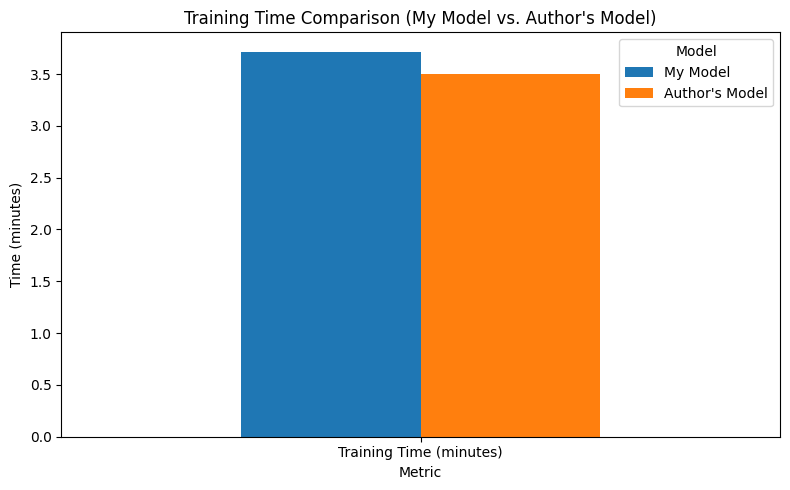

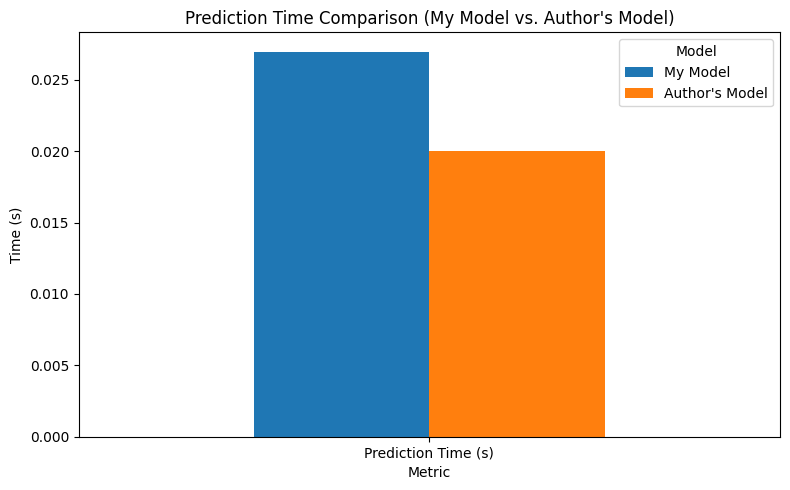

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

# Use the correct times
# total_training_time is in seconds, convert to minutes
training_time_corrected = total_training_time / 60

# Store the performance results
performance_results = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'My Model': [accuracy_lr, precision_lr, recall_lr, f1_lr],
    'Author\'s Model': [0.934, 0.927, 0.943, 0.941]
}

performance_results_df = pd.DataFrame(performance_results)

# Store the time results
time_results = {
    'Metric': ['Training Time (minutes)', 'Prediction Time (s)'],
    'My Model': [training_time_corrected, prediction_time_lr],
    'Author\'s Model': [210 / 60, 0.02] # Author's training time in minutes
}

time_results_df = pd.DataFrame(time_results)


print("\n--- Model Performance Comparison ---")
display(performance_results_df)

print("\n--- Model Time Comparison ---")
display(time_results_df)

# Bar chart for performance metrics
performance_results_df.set_index('Metric').plot(kind='bar', figsize=(10, 6))
plt.title('Model Performance Comparison (My Model vs. Author\'s Model)')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

# Bar chart for Training Time
training_time_df = time_results_df[time_results_df['Metric'] == 'Training Time (minutes)'].set_index('Metric')
training_time_df.plot(kind='bar', figsize=(8, 5))
plt.title('Training Time Comparison (My Model vs. Author\'s Model)')
plt.ylabel('Time (minutes)')
plt.xticks(rotation=0)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

# Bar chart for Prediction Time
prediction_time_df = time_results_df[time_results_df['Metric'] == 'Prediction Time (s)'].set_index('Metric')
prediction_time_df.plot(kind='bar', figsize=(8, 5))
plt.title('Prediction Time Comparison (My Model vs. Author\'s Model)')
plt.ylabel('Time (s)')
plt.xticks(rotation=0)
plt.legend(title='Model')
plt.tight_layout()
plt.show()
